In [12]:
# !git clone https://github.com/time-series-foundation-models/lag-llama/
# !pip3 install -r requirements.txt --quiet
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir lag-llama

In [1]:
cd lag-llama

/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama


In [43]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from tqdm.autonotebook import tqdm

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
# from gluonts.dataset.repository.datasets import get_dataset

# from gluonts.dataset.pandas import PandasDataset
# from gluonts.dataset.split import split
from gluonts.dataset.common import ListDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
import seaborn as sns

from sklearn.metrics import mean_absolute_error

In [3]:
# Read data
# ==============================================================================
data_dir = '../Data/spain/four years'
# data_dir = '../Data/spain/one year'

df = pd.read_csv(data_dir + '/spain_clean.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('60min')
# df['item_id'] = 'waves'
df.drop(columns = ['period'], inplace = True)
df.head()

# Train-test split
# ==============================================================================
# one_month = (-1)*30*24 # One month
two_months = (-1)*60*24 # Two months

end_train = two_months # + two_months
# end_val = two_months

df_train = df.iloc[:end_train].copy()
# df_val = df.iloc[end_train:end_val].copy()
# df_test = df.iloc[end_val:].copy()
df_test = df.iloc[end_train:]

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
# print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2020-06-18 00:00:00 --- 2024-04-19 23:00:00  (n=33648)
Test dates       : 2024-04-20 00:00:00 --- 2024-06-18 23:00:00  (n=1440)


In [4]:
def create_gluonts_dataset(df, freq, target_column):
    series = {
        "start": df.index[0],  # start date of the time series
        "target": df[target_column].values,  # target values
    }
    
    dataset = ListDataset([series], freq=freq)
    return dataset

# Create the GluonTS dataset
train = create_gluonts_dataset(df_train, freq='1H', target_column='wave_height')
test = create_gluonts_dataset(df_test, freq='1H', target_column='wave_height')

print(train)
print(test)

[{'start': Period('2020-06-18 00:00', 'H'), 'target': array([0.78, 0.76, 0.74, ..., 1.39, 1.33, 1.26], dtype=float32)}]
[{'start': Period('2024-04-20 00:00', 'H'), 'target': array([1.2 , 1.15, 1.11, ..., 0.86, 0.84, 0.82], dtype=float32)}]


We create a function for Lag-Llama inference that we can reuse. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where `num_samples` is the number of samples sampled from the predicted probability distribution for each timestep.

In [5]:
    def get_lag_llama_predictions(dataset, prediction_length, context_length=32, num_samples=20, device="cpu", batch_size=1, nonnegative_pred_samples=True):
        ckpt = torch.load("lag-llama/lag-llama.ckpt", map_location=torch.device(device))
        estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

        estimator = LagLlamaEstimator(
            # ckpt_path="lag-llama.ckpt",
            ckpt_path = 'lag-llama/lag-llama.ckpt',
            prediction_length=prediction_length,
            context_length=context_length,
            device = device,

            # estimator args
            input_size=estimator_args["input_size"],
            n_layer=estimator_args["n_layer"],
            n_embd_per_head=estimator_args["n_embd_per_head"],
            n_head=estimator_args["n_head"],
            scaling=estimator_args["scaling"],
            time_feat=estimator_args["time_feat"],

            nonnegative_pred_samples=nonnegative_pred_samples,

            # linear positional encoding scaling
            rope_scaling={
                "type": "linear",
                "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
            },

            batch_size=batch_size,
            num_parallel_samples=num_samples,
        )

        lightning_module = estimator.create_lightning_module().to(device)
        transformation = estimator.create_transformation()
        predictor = estimator.create_predictor(transformation, lightning_module)

        forecast_it, ts_it = make_evaluation_predictions(
            dataset=dataset,
            predictor=predictor,
            num_samples=num_samples
        )
        forecasts = list(tqdm(forecast_it, total=len(dataset[0]['target']), desc="Forecasting batches"))
        tss = list(tqdm(ts_it, total=len(dataset[0]['target']), desc="Ground truth"))

        return forecasts, tss

In [77]:
# Forecast parameters
prediction_length = 24
context_length = 32
num_samples = 100
device = torch.device('cpu')

In [78]:
forecasts, tss = get_lag_llama_predictions(
    test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/1440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1440 [00:00<?, ?it/s]

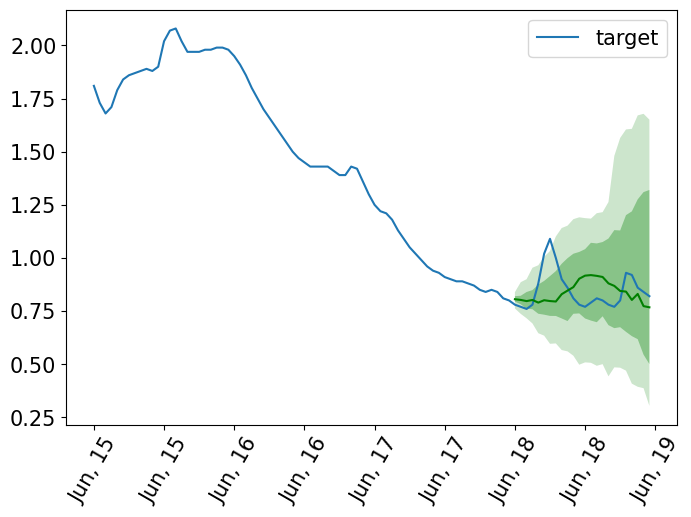

In [79]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [35]:
# Recursive multi-step forecasting
# ==============================================================================
context_df = df_train[-48:]
context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')

batch_size = 24  # Number of observations per batch
total_length = len(df_test)  # Total length of the target DataFrame

prediction_length = batch_size
context_length = prediction_length*2
num_samples = 20
device = torch.device('cpu')

all_point_forecasts = []

# Append batches sequentially to the target DataFrame
for i in range(0, total_length, batch_size):

    # Prediction based on context dataset
    forecasts, tss = get_lag_llama_predictions(
    context_gdf,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
    )

    point_forecast = list(forecasts[0].mean)
    all_point_forecasts.extend(point_forecast)

    # Update context dataset
    batch_start_index = i
    batch_end_index = min(i + batch_size, total_length)  # Ensure not to exceed the length of target_df
    batch = df_test.iloc[batch_start_index:batch_end_index]
    context_df = pd.concat([source_df, batch], ignore_index=False)
    context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')


Forecasting batches:   0%|          | 0/48 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/48 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

In [39]:
df_test['forecast'] = all_point_forecasts
df_test

/var/folders/x7/k4v9jmwn26x9tw0wd3vfqdw00000gn/T/ipykernel_71777/4039081769.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['forecast'] = all_point_forecasts


,wave_height,forecast
datetime,,
2024-04-20 00:00:00,1.20,1.265803
2024-04-20 01:00:00,1.15,1.179225
2024-04-20 02:00:00,1.11,1.371446
2024-04-20 03:00:00,1.08,1.392191
2024-04-20 04:00:00,1.08,1.330754
...,...,...
2024-06-18 19:00:00,0.93,0.995901
2024-06-18 20:00:00,0.92,1.030207
2024-06-18 21:00:00,0.86,1.048877


In [42]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=df_test.index, y=df_test['wave_height'], name="actual", mode="lines")
trace2 = go.Scatter(x=df_test.index, y=df_test['forecast'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Actual value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Wave height (meters)",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

fig.show()

In [44]:
metric = mean_absolute_error(df_test['wave_height'], df_test['forecast'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.31484198255836965


## Fine-tuning

Let us fine-tune the Lag-Llama base model with a few data-specific changes. Feel Free to change the hyperparameters below:

In [45]:
# Forecast parameters
prediction_length = 24
context_length = prediction_length*3
num_samples = 20
device = torch.device('cpu')

In [46]:
ckpt = torch.load("lag-llama/lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        device = device,

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        },

        batch_size=64,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )

In [47]:
predictor = estimator.train(train, cache_data=True, shuffle_buffer_length=1000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.65533 (best 0.65533), saving model to '/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached -0.29596 (best -0.29596), saving model to '/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached -1.12429 (best -1.12429), saving model to '/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached -1.42102 (best -1.42102), saving model to '/Users/alvarocorralescano/Documents/GitHub/wave-height-prediction/lag-llama/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5,

In [51]:
# Recursive multi-step forecasting
# ==============================================================================
context_df = df_train[-48:]
context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')

batch_size = 24  # Number of observations per batch
total_length = len(df_test)  # Total length of the target DataFrame

prediction_length = batch_size
context_length = prediction_length*2
num_samples = 20
device = torch.device('cpu')

all_point_forecasts = []

# Append batches sequentially to the target DataFrame
for i in range(0, total_length, batch_size):

    # Prediction based on context dataset
    forecasts, tss = get_lag_llama_predictions(
    context_gdf,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
    )

    point_forecast = list(forecasts[0].mean)
    all_point_forecasts.extend(point_forecast)

    # Update context dataset
    batch_start_index = i
    batch_end_index = min(i + batch_size, total_length)  # Ensure not to exceed the length of target_df
    batch = df_test.iloc[batch_start_index:batch_end_index]
    context_df = pd.concat([source_df, batch], ignore_index=False)
    context_gdf = create_gluonts_dataset(context_df, freq='1H', target_column='wave_height')


Forecasting batches:   0%|          | 0/48 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/48 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

Forecasting batches:   0%|          | 0/1512 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1512 [00:00<?, ?it/s]

In [52]:
df_test['forecast'] = all_point_forecasts
df_test

/var/folders/x7/k4v9jmwn26x9tw0wd3vfqdw00000gn/T/ipykernel_71777/4039081769.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,wave_height,forecast
datetime,,
2024-04-20 00:00:00,1.20,1.325206
2024-04-20 01:00:00,1.15,1.301366
2024-04-20 02:00:00,1.11,1.132968
2024-04-20 03:00:00,1.08,1.419668
2024-04-20 04:00:00,1.08,1.320705
...,...,...
2024-06-18 19:00:00,0.93,0.986186
2024-06-18 20:00:00,0.92,0.957678
2024-06-18 21:00:00,0.86,0.956115


In [53]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=df_test.index, y=df_test['wave_height'], name="actual", mode="lines")
trace2 = go.Scatter(x=df_test.index, y=df_test['forecast'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Actual value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Wave height (meters)",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    )
)

fig.show()

In [54]:
metric = mean_absolute_error(df_test['wave_height'], df_test['forecast'])
print(f"Backtest error (MAE): {metric}")

Backtest error (MAE): 0.32669270664287936


In [57]:
forecasts, tss = get_lag_llama_predictions(
    test,
    prediction_length=prediction_length,
    num_samples=num_samples,
    context_length=context_length,
    device=device
)

Forecasting batches:   0%|          | 0/1440 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/1440 [00:00<?, ?it/s]

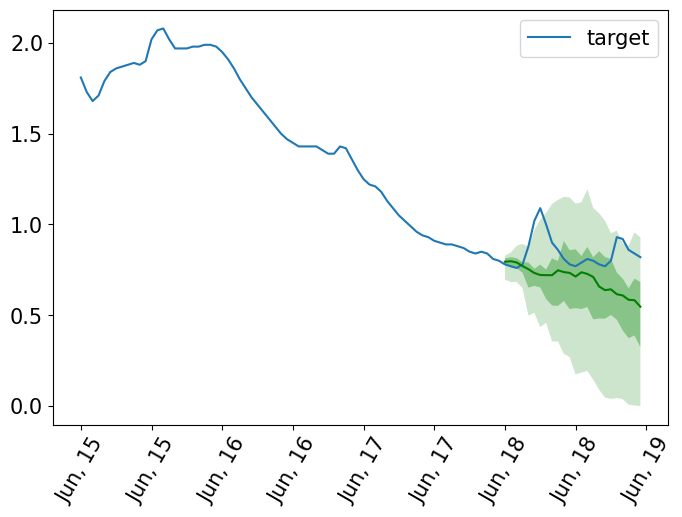

In [58]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()